<a href="https://colab.research.google.com/github/roni-dot/MyFirstProject/blob/master/Copy_of_Project_1_Surprisals_and_RTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

The following code provides you with surprisal values for the same data you used in Homework 2.  The surprisal values are based on the output of an RNN model.

We leave it up to you to perform the alignment between the model output and the reading times!

Feel free to skim through the code, it might be helpful for the semi-structured and open-ended tasks!

## Set up dependencies and data

Run the cell below to fetch the recurrent neural network codebase we've designed for this assignment.

It will leave the files in a directory called `rnn` (check in the sidebar after you've run the command).

In [ ]:
%%bash
git clone https://github.com/scaperex/neural-complexity.git rnn
mkdir -p rnn/data/ptb

Cloning into 'rnn'...


## Mount Google Drive

We'll save your corpus data, model checkpoints, and output to Google Drive for safekeeping.

Follow the instructions in the output of this command to link your Drive account.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"

## Upload corpus files for LM training

Here we upload the Penn Treebank corpus files  to the `rnn/data/ptb` folder.
Your files should be named:

- `ptb_tok_train.txt`
- `ptb_tok_dev.txt`

In [ ]:
!wget -qO rnn/data/ptb/ptb_tok_train.txt https://gist.githubusercontent.com/omershubi/cdd4231472d6188f03ab21e2b2729fee/raw/e1b4c764561fd038470830534baaa220b0eb4c6d/ptb_tok_train.txt
!wget -qO rnn/data/ptb/ptb_tok_dev.txt https://gist.githubusercontent.com/omershubi/31eff71b74dfb8cfe93d1a9acf8ab523/raw/094d3094b06beb92cd7fd0496710cf43273f8c64/ptb_tok_dev.txt
!cp rnn/data/ptb/* "$GDRIVE_DIR/corpus_data/"

# Recurrent neural network modeling

## Train model

Now we're ready to begin training the model. The below command will launch the neural network optimization procedure, and progressively save checkpoints to the Google Drive you've just mounted. The neural network train for 40 epochs (1 epoch = 1 loop through the training dataset), which should take approximately **2 hours**.

Checkpoints will be saved each time the validation loss improves, and named `ptb_model.pt`. Watch the output of the command below to see how the model's train and validation perplexity improve over time.

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname ptb_tok_train.txt --validfname ptb_tok_dev.txt

Libraries loaded
| epoch   1 |   200/ 1422 batches | lr 20.00 | ms/batch 18.17 | loss  6.73 | ppl   837.07
| epoch   1 |   400/ 1422 batches | lr 20.00 | ms/batch 12.18 | loss  6.04 | ppl   421.34
| epoch   1 |   600/ 1422 batches | lr 20.00 | ms/batch 12.33 | loss  5.90 | ppl   365.32
| epoch   1 |   800/ 1422 batches | lr 20.00 | ms/batch 12.37 | loss  5.83 | ppl   341.77
| epoch   1 |  1000/ 1422 batches | lr 20.00 | ms/batch 12.32 | loss  5.84 | ppl   342.74
| epoch   1 |  1200/ 1422 batches | lr 20.00 | ms/batch 12.38 | loss  5.78 | ppl   324.46
| epoch   1 |  1400/ 1422 batches | lr 20.00 | ms/batch 12.40 | loss  5.82 | ppl   336.83
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 18.89s | lr: 20.00000000 | valid ppl   270.29
-----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1422 batches | lr 20.00 | ms/batch 12.55 | loss  5.83 | ppl   339.01
| epoch   

## Compute surprisals

Now we'll compute model surprisals for the text data in `brown.txt` (already downloaded for you). This will output a file called `rnn_surprisals.tsv` to your Google Drive, which you'll use in the next steps of the analysis.

We'll load the checkpoint and use it to extract per-token surprisal estimates.

In [ ]:

checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model.pt"

In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/rnn_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


Cool, let's check that the surprisal output looks right. (Compare with the ngram model surprisals from before.)

In [ ]:
import pandas as pd
rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals.tsv',sep=' ')
rnn_surprisals

,word,sentid,sentpos,wlen,surp,entropy,entred
0,In,0,0,2,5.506053,9.515585,0.000000
1,<unk>,0,1,5,6.578504,7.866125,1.649460
2,County,0,2,6,12.514248,6.056062,1.810063
3,<unk>,0,3,5,7.031470,8.524199,0.000000
4,near,0,4,4,13.308077,8.640187,0.000000
...,...,...,...,...,...,...,...
7229,as,363,15,2,6.248776,4.505761,3.256542
7230,a,363,16,1,2.861911,7.777086,0.000000
7231,leader,363,17,6,11.365563,11.206182,0.000000
7232,and,363,18,3,6.632089,5.544580,5.661602


## Harmonize RNN surprisal and RT data

Load and align the reading times with the n-gram model surprisals.
You may load the harmonized csv from Homework 2, or align it again.

Finallyy, align the RNN model-derived surprisal values with human reading times. The harmonize function you wrote in Homework 2 may be helpful here too.

Note, modifications may be required as the tokenization is not necessarily the same as the n-gram model.

In [ ]:
import numpy as np

ngram_surprisals = pd.read_csv('https://gist.githubusercontent.com/omershubi/f19f77f5157f7ba7ea1adf72a72847da/raw/d5d553b1217ea70fe3261ce5d9a0532f29769817/5gram_surprisals.tsv', index_col=False, sep='\t')
sprt = pd.read_csv('https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code')

Cells for question 1 in the structured part

In [ ]:
ngram_surprisals

,sentence_id,token_id,token,surprisal
0,1,1,In,4.57937
1,1,2,<unk>,7.45049
2,1,3,County,12.65410
3,1,4,<unk>,6.11317
4,1,5,near,12.22380
...,...,...,...,...
7693,464,17,a,3.23962
7694,464,18,leader,12.81650
7695,464,19,and,5.90348
7696,464,20,<unk>,4.62292


In [ ]:
sprt

,word,code,subject,text_id,text_pos,word_in_exp,time
2286,In,17000,s001,0,0,2285,399.90
109460,In,17000,s028,0,0,2503,290.32
50709,In,17000,s014,0,0,1394,501.59
80486,In,17000,s021,0,0,2525,210.93
35626,In,17000,s010,0,0,579,862.35
...,...,...,...,...,...,...,...
79391,captain.,35763,s021,12,763,1430,425.18
116505,captain.,35763,s030,12,763,1489,383.32
26975,captain.,35763,s007,12,763,3426,506.40
15206,captain.,35763,s004,12,763,3528,669.29


In [ ]:
# TODO
import string
import numpy as np

def remove_panc(s):
  s = s.lower()
  s = s.translate(str.maketrans('', '', string.punctuation))
  return s

def harmonize(rt_data: pd.DataFrame, surprs_data: pd.DataFrame, word) -> pd.DataFrame:

  sup_change = surprs_data.copy()
  sup_change.drop(sup_change[sup_change[word] == '</s>'].index, inplace = True)



  sprt_change = rt_data.copy()
  sprt_change['word'] = sprt_change['word'].apply(remove_panc)
  sup_change[word] = sup_change[word].apply(remove_panc)
  # sup_change.drop(sup_change[sup_change['token'] == ''].index, inplace = True)
  sup_change = sup_change.reset_index().drop('index', axis=1)

  codes = list(set(rt_data['code']))
  codes.sort()
  for i, c in enumerate(codes):
    if i%5000 == 0:
      print(i)
    w = list(sprt_change[sprt_change['code'] == c]['word'])[0]
    # print("yy",sup_change[word][46887])
    if w != sup_change[word][i] and sup_change[word][i] != 'unk':
      del_indexes = []
      new_str = ''
      j = i

      while(sup_change[word][j] != w and sup_change[word][j] != 'unk' and new_str != w):
        del_indexes.append(j)
        new_str += sup_change[word][j].translate({ord(c): None for c in string.whitespace})
        if new_str != w:
          new_str += " "
        j += 1
      sup_change.loc[del_indexes[0], word] = new_str
      if len(del_indexes) < 2:
        sup_change.drop(del_indexes[0], axis=0, inplace=True)
      else:
        sup_change.drop(del_indexes[1], axis=0, inplace=True)
      sup_change = sup_change.reset_index().drop('index', axis=1)

  print("finito")
  harmonised = sup_change.copy()
  harmonised['avg_rt'] = 0
  for i, c in enumerate(codes):
    harmonised.loc[i,['avg_rt']] = np.mean(list(sprt_change[sprt_change['code'] == c]['time']))
  return harmonised

In [ ]:
harmonized_ngram = harmonize(sprt, ngram_surprisals, 'token')
harmonized_ngram.drop(harmonized_ngram[harmonized_ngram['token'] == ''].index, inplace = True)
harmonized_ngram.drop(harmonized_ngram[harmonized_ngram['token'] == 'unk'].index, inplace = True)

harmonized_rnn = harmonize(sprt, rnn_surprisals, 'word')
harmonized_rnn.drop(harmonized_rnn[harmonized_rnn['word'] == ''].index, inplace = True)
harmonized_rnn.drop(harmonized_rnn[harmonized_rnn['word'] == 'unk'].index, inplace = True)

0
5000
finito
0
5000
finito


In [ ]:

import statsmodels.api as sm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)

In [ ]:
def analysis(df, surp_name):

  ### Fit and summarize OLS model

  X=df[surp_name]
  Y=df.avg_rt
  X=sm.add_constant(X)
  model=sm.OLS(Y, X)
  lin_model=model.fit()
  print(lin_model.summary())


  ### scatterplot with best-fit line, without binning RT values

  g = sns.jointplot(x=surp_name, y="avg_rt", data=df, kind='reg', scatter_kws={'s': 1})
  # We're going to make the regression line red so it's easier to see
  regline = g.ax_joint.get_lines()[0]
  regline.set_color('red')
  plt.show()

  ### scatterplot with best-fit line, with binning RT values.
  g = sns.regplot(x=surp_name, y="avg_rt", data=df, x_bins=15)

  plt.show()


                            OLS Regression Results                            
Dep. Variable:                 avg_rt   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     183.7
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           3.40e-41
Time:                        16:19:20   Log-Likelihood:                -29514.
No. Observations:                5461   AIC:                         5.903e+04
Df Residuals:                    5459   BIC:                         5.904e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        289.1112      1.662    173.923      0.0

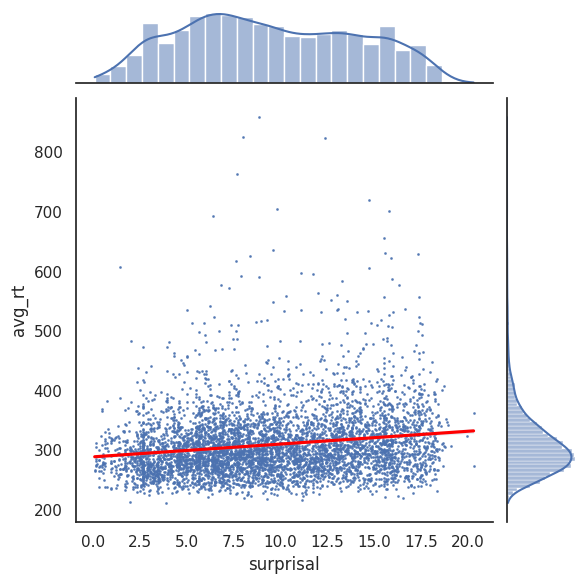

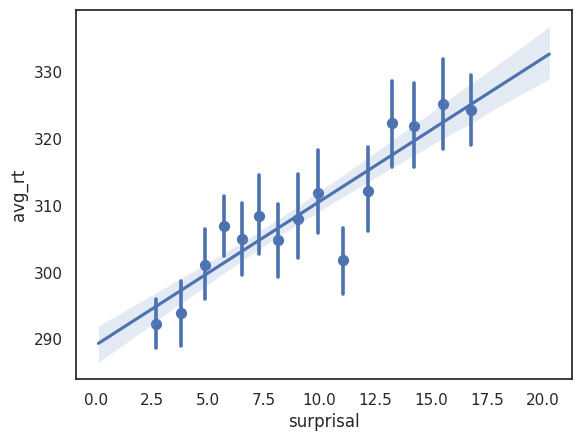

In [ ]:
analysis(harmonized_ngram, 'surprisal')

                            OLS Regression Results                            
Dep. Variable:                 avg_rt   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     198.6
Date:                Tue, 04 Jul 2023   Prob (F-statistic):           2.45e-44
Time:                        16:19:23   Log-Likelihood:                -29507.
No. Observations:                5461   AIC:                         5.902e+04
Df Residuals:                    5459   BIC:                         5.903e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        289.3275      1.597    181.166      0.0

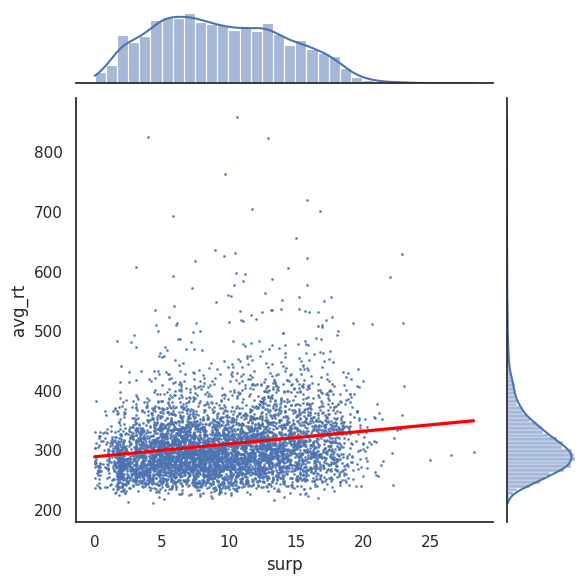

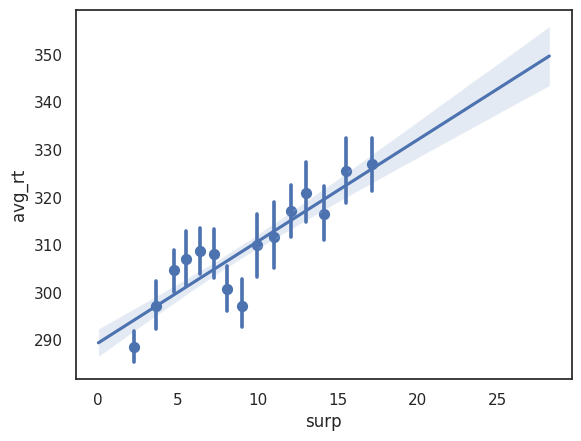

In [ ]:
analysis(harmonized_rnn, 'surp')

Cells for question 2 in the structured part

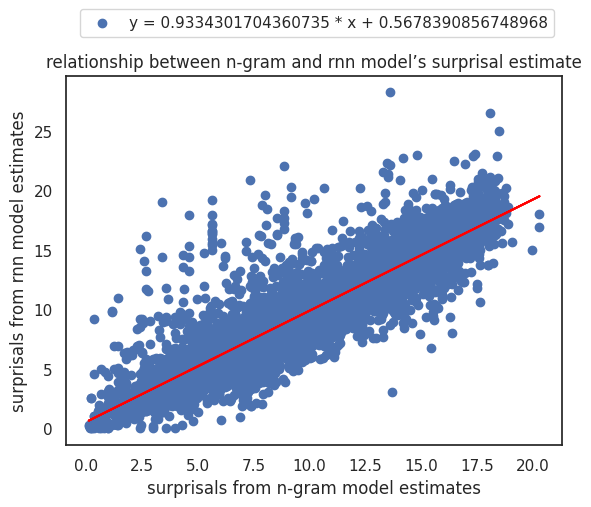

In [ ]:
x = list(harmonized_ngram.surprisal)
y = list(harmonized_rnn.surp)

m, b = np.polyfit(x, y, 1)
plt.scatter(x, y, label='y = '+str(m)+" * x + "+str(b))
y_new = [point*m+b for point in x]
plt.plot(x, y_new, color='red')
plt.title("relationship between n-gram and rnn model’s surprisal estimate")
plt.xlabel("surprisals from n-gram model estimates")
plt.ylabel("surprisals from rnn model estimates")
plt.legend(bbox_to_anchor=(1, 1.2))
plt.show()

Cells for question 3 in the structured part

In [ ]:
harmonized_rnn['surp_ngram'] = harmonized_ngram['surprisal']
harmonized_rnn

,word,sentid,sentpos,wlen,surp,entropy,entred,avg_rt,surp_ngram
0,in,0,0,2,5.506053,9.515585,0.000000,380.275294,4.57937
2,county,0,2,6,12.514248,6.056062,1.810063,296.042941,12.65410
4,near,0,4,4,13.308077,8.640187,0.000000,403.553529,12.22380
5,the,0,5,3,1.662673,7.870934,0.769253,306.075882,1.98095
6,river,0,6,5,17.830992,11.037002,0.000000,289.048235,15.70900
...,...,...,...,...,...,...,...,...,...
7182,failed,363,14,6,9.048445,7.762303,0.462083,292.772500,8.25341
7183,as,363,15,2,6.248776,4.505761,3.256542,284.470833,9.42416
7184,a,363,16,1,2.861911,7.777086,0.000000,282.622083,3.23962
7185,leader,363,17,6,11.365563,11.206182,0.000000,279.445417,12.81650


In [ ]:
new_df = harmonized_rnn[abs(harmonized_rnn['surp']-harmonized_rnn['surp_ngram']) >=10]
new_df['avg_of_avg_rt'] = np.mean(harmonized_rnn.avg_rt)
list_sentid = list(new_df.sentid)
list_pos = list(new_df.sentpos)
new_df[['word', 'surp', 'surp_ngram', 'sentid', 'sentpos', 'avg_rt', 'avg_of_avg_rt']]

<ipython-input-20-2b31180f76a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['avg_of_avg_rt'] = np.mean(harmonized_rnn.avg_rt)


,word,surp,surp_ngram,sentid,sentpos,avg_rt,avg_of_avg_rt
318,officer,14.083010,2.57989,9,12,284.850000,309.365854
1027,he,16.443302,5.63280,45,39,271.447857,309.365854
1301,he,16.584312,5.63280,57,6,320.562857,309.365854
1459,she,22.015818,8.86122,64,5,590.187368,309.365854
1478,john,28.235905,13.59450,65,3,296.856316,309.365854
1840,frequency,15.100250,2.42276,77,47,320.135263,309.365854
1902,the,16.147221,2.68215,79,24,264.095789,309.365854
2176,he,17.962000,5.63280,94,22,284.794348,309.365854
2359,he,16.633633,5.63280,103,18,270.006522,309.365854
2721,away,14.566018,4.32966,117,47,301.133684,309.365854


In [ ]:
for id, pos in zip(list_sentid, list_pos):
  print(" ".join(list(rnn_surprisals[rnn_surprisals['sentid'] == id].word)[pos-1:pos+2]))

commanding officer of
<unk> He <unk>
<unk> He fired
<unk> She was
the John <unk>
increasing frequency from
<unk> The following
<unk> He knew
<unk> He urged
far away as
<unk> He <unk>
<unk> He <unk>
<unk> He tilted
<unk> He <unk>
<unk> There was
War I <unk>
War I flying
Pete the night

<unk> We pulled
<unk> Then the
miles west of
<unk> The young
<unk> Then he
<unk> But everyone
<unk> He named
<unk> In <unk>


Cells for question 4 in the structured part

In [ ]:
full_harmonized_ngram = harmonize(sprt, ngram_surprisals, 'token') ### harmonized with unk
full_harmonized_ngram['raw_probability'] = np.power(2, -full_harmonized_ngram.surprisal)

def next_rt_ngram(x):
  s_id = x['sentence_id']
  t_id = x['token_id']
  temp = full_harmonized_ngram[full_harmonized_ngram['sentence_id'] == s_id]
  if len(list(temp[temp['token_id'] == t_id+1].avg_rt)):
    return list(temp[temp['token_id'] == t_id+1].avg_rt)[0]
  else:
    return None
full_harmonized_ngram['next_word_rt'] = full_harmonized_ngram.apply(next_rt_ngram, axis=1)

### the last word has no "next word"
full_harmonized_ngram.drop(full_harmonized_ngram[full_harmonized_ngram['next_word_rt'].isnull()].index, inplace = True)

0
5000
finito


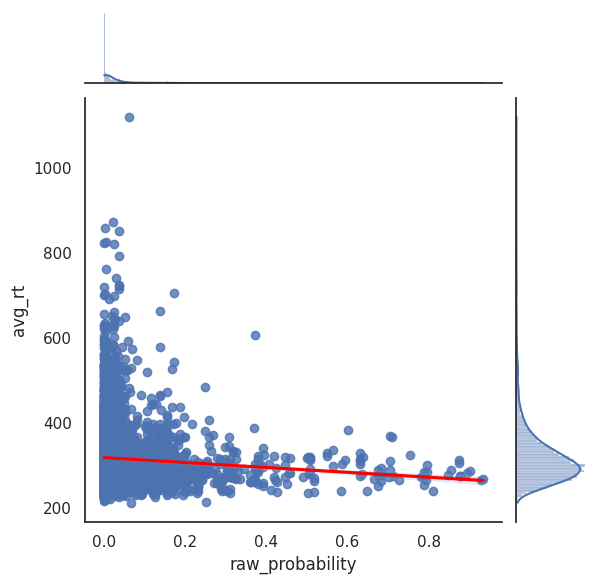

In [ ]:
### raw_prob and current rt graph

g = sns.jointplot(x="raw_probability", y="avg_rt", data=full_harmonized_ngram, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

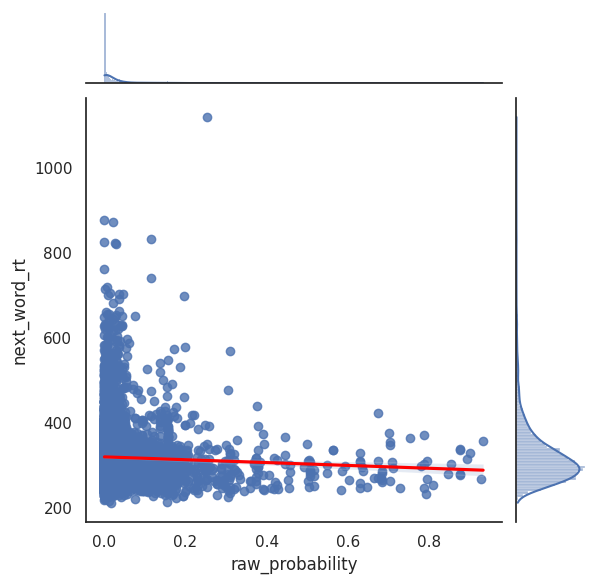

In [ ]:
### raw_prob and next rt graph

g = sns.jointplot(x="raw_probability", y="next_word_rt", data=full_harmonized_ngram, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')


In [ ]:
harmonized_rnn

,word,sentid,sentpos,wlen,surp,entropy,entred,avg_rt,surp_ngram
0,in,0,0,2,5.506053,9.515585,0.000000,380.275294,4.57937
2,county,0,2,6,12.514248,6.056062,1.810063,296.042941,12.65410
4,near,0,4,4,13.308077,8.640187,0.000000,403.553529,12.22380
5,the,0,5,3,1.662673,7.870934,0.769253,306.075882,1.98095
6,river,0,6,5,17.830992,11.037002,0.000000,289.048235,15.70900
...,...,...,...,...,...,...,...,...,...
7182,failed,363,14,6,9.048445,7.762303,0.462083,292.772500,8.25341
7183,as,363,15,2,6.248776,4.505761,3.256542,284.470833,9.42416
7184,a,363,16,1,2.861911,7.777086,0.000000,282.622083,3.23962
7185,leader,363,17,6,11.365563,11.206182,0.000000,279.445417,12.81650


In [ ]:
full_harmonized_rnn = harmonize(sprt, rnn_surprisals, 'word') ### harmonized with unk
full_harmonized_rnn['raw_probability'] = np.power(2, -full_harmonized_rnn.surp)

def next_rt_rnn(x):
  s_id = x['sentid']
  t_id = x['sentpos']
  temp = full_harmonized_rnn[full_harmonized_rnn['sentid'] == s_id]
  if len(list(temp[temp['sentpos'] == t_id+1].avg_rt)):
    return list(temp[temp['sentpos'] == t_id+1].avg_rt)[0]
  else:
    return None
full_harmonized_rnn['next_word_rt'] = full_harmonized_rnn.apply(next_rt_rnn, axis=1)

### the last word has no "next word"
full_harmonized_rnn.drop(full_harmonized_rnn[full_harmonized_rnn['next_word_rt'].isnull()].index, inplace = True)

0
5000
finito


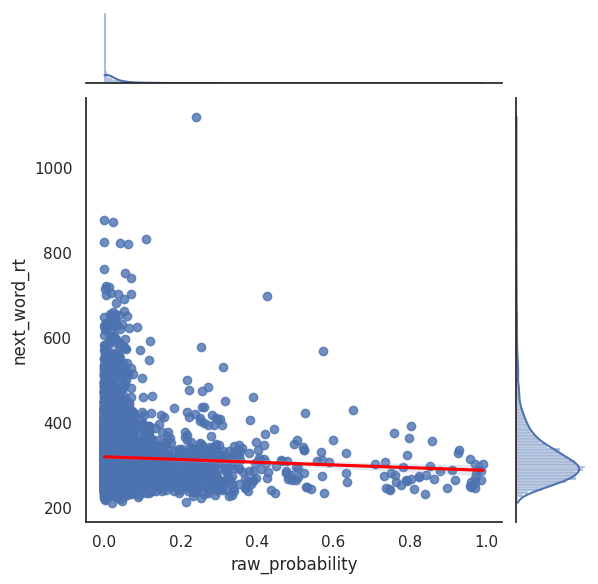

In [ ]:
g = sns.jointplot(x="raw_probability", y="next_word_rt", data=full_harmonized_rnn, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

In [ ]:
temp = sprt[sprt['text_pos'] == 205]
sprt[sprt['time'] > 1000]

,word,code,subject,text_id,text_pos,word_in_exp,time
50712,"Limerick,",17003,s014,0,3,1397,1181.94
65573,near,17004,s018,0,4,4,1287.17
65588,which,17019,s018,0,19,19,2953.22
65592,"Owen.""",17023,s018,0,23,23,2756.57
88530,none,17025,s023,0,25,908,1360.21
...,...,...,...,...,...,...,...
92373,Ahead,35739,s023,12,739,4751,1141.88
1633,"perilous,",35741,s001,12,741,1632,1180.49
92376,ice-filled,35742,s023,12,742,4754,1130.82
119096,dangerous,35753,s031,12,753,1220,1447.75


Cells for the open- ended task

In [ ]:
harmonized_ngram['raw_probability'] = np.power(2, -harmonized_ngram.surprisal)
med_raw_probability = np.median(harmonized_ngram.raw_probability)
med_of_avg_rt = np.median(harmonized_ngram.avg_rt)

In [ ]:
med_of_avg_rt

299.135652173913

In [ ]:

spillover = harmonized_ngram[harmonized_ngram['raw_probability'] < med_raw_probability/100]
spillover = spillover[spillover['avg_rt'] > med_of_avg_rt*1.2]

In [ ]:
spillover

,sentence_id,token_id,token,surprisal,avg_rt,raw_probability
19,1,20,which,15.7846,527.038824,0.000018
77,4,23,sioux,17.3111,500.071176,0.000006
80,4,26,mexican,15.7486,377.603529,0.000018
132,7,21,organizational,17.6471,411.562941,0.000005
133,7,22,charts,16.1947,388.888824,0.000013
...,...,...,...,...,...,...
6696,438,26,towns,16.5980,373.646250,0.000010
6742,440,27,sailing,16.1995,377.102500,0.000013
6878,447,3,half,18.1965,395.339167,0.000003
6905,448,4,hudson,15.9749,373.472500,0.000016


In [ ]:
t = {"sentence_id": [], "token_id": [], "token": [], "surprisal": [], "avg_rt": [], "raw_probability": []}
spillover_df = pd.DataFrame(data=t)
for sen_id, token_id in zip(list(spillover.sentence_id), list(spillover.token_id)):
  temp = harmonized_ngram[harmonized_ngram['sentence_id'] == sen_id]
  temp = temp[temp['token_id'] == token_id + 1]
  spillover_df = pd.concat([spillover_df, temp], axis=0)

def avg_raw_prob_ngram(x):
  token = x['token']
  return "p"

s = spillover_df[spillover_df['raw_probability'] > med_raw_probability]
s[s['avg_rt'] > med_of_avg_rt]
s['avg_prop'] = s.apply(avg_raw_prob_ngram, axis=1)

<ipython-input-33-8a7186e5fc48>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['avg_prop'] = s.apply(avg_raw_prob_ngram, axis=1)


# Next Steps

For the next steps, follow the PDF project instructions.

Good luck!

# Semi-Structuerd Tasks

# Task 1

In [ ]:
full_harmonized_rnn

,word,sentid,sentpos,wlen,surp,entropy,entred,avg_rt,raw_probability,next_word_rt
0,in,0,0,2,5.506053,9.515585,0.000000,380.275294,0.022005,335.850588
1,unk,0,1,5,6.578504,7.866125,1.649460,335.850588,0.010463,296.042941
2,county,0,2,6,12.514248,6.056062,1.810063,296.042941,0.000171,481.850000
3,unk,0,3,5,7.031470,8.524199,0.000000,481.850000,0.007644,403.553529
4,near,0,4,4,13.308077,8.640187,0.000000,403.553529,0.000099,306.075882
...,...,...,...,...,...,...,...,...,...,...
7182,failed,363,14,6,9.048445,7.762303,0.462083,292.772500,0.001889,284.470833
7183,as,363,15,2,6.248776,4.505761,3.256542,284.470833,0.013150,282.622083
7184,a,363,16,1,2.861911,7.777086,0.000000,282.622083,0.137556,279.445417
7185,leader,363,17,6,11.365563,11.206182,0.000000,279.445417,0.000379,299.705000


In [ ]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 84.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.


In [ ]:
#calculate log frequencies and add the information as a new column in harmonized_ngram.csv
from collections import Counter

lst = []
with open('/content/rnn/data/ptb/ptb_tok_train.txt') as f:
    lines = f.readlines()
    for line in lines:
      lst += line.split()
for i in range(len(lst)):
  lst[i] = remove_panc(lst[i])

counter = Counter(lst)


def count_frequency(x):
  s = counter[x]
  return np.log2(s+1)

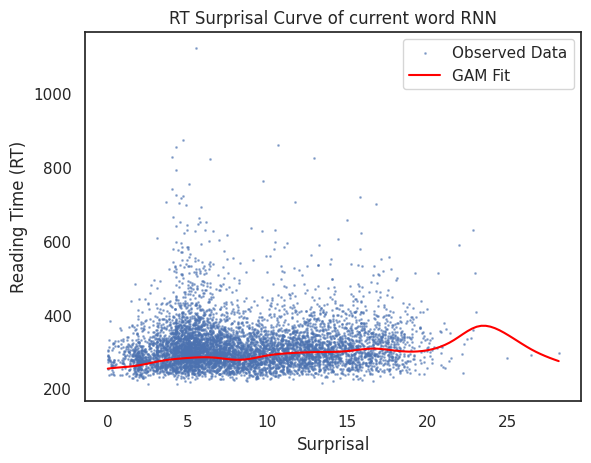

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     41.8786
Link Function:                     IdentityLink Log Likelihood:                                -62035.6349
Number of Samples:                         6778 AIC:                                            124157.027
                                                AICc:                                          124157.5858
                                                GCV:                                             3807.0336
                                                Scale:                                            3764.717
                                                Pseudo R-Squared:                                   0.0921
Feature Function                  Lam

<ipython-input-37-8009db55ff66>:35: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_model.summary()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM, s


### GAM surprisal estimates and rts

# Preprocess the data
data_rnn = full_harmonized_rnn.copy()
data_rnn['log_frequency'] = data_rnn['word'].apply(count_frequency)
data_rnn['map1'] = data_rnn['log_frequency'] * data_rnn['wlen']

# Extract relevant columns for the GAM model
X = data_rnn[['surp', 'log_frequency', 'wlen']].values
y = data_rnn['avg_rt'].values

# Fit the GAM model
gam_model = LinearGAM(s(0) + s(1) + s(2)).fit(X, y)

# Generate grid values for predictors
X_grid = gam_model.generate_X_grid(term=0, n=100)

# Predict the response variable using the fitted GAM model
y_pred = gam_model.predict(X_grid)

# Plot the RT surprisal curve
plt.scatter(data_rnn['surp'], data_rnn['avg_rt'], alpha=0.5, label='Observed Data', s=1)
plt.plot(X_grid[:, 0], y_pred, color='red', label='GAM Fit')
plt.xlabel('Surprisal')
plt.ylabel('Reading Time (RT)')
plt.legend()
plt.title('RT Surprisal Curve of current word RNN')
plt.show()
gam_model.summary()

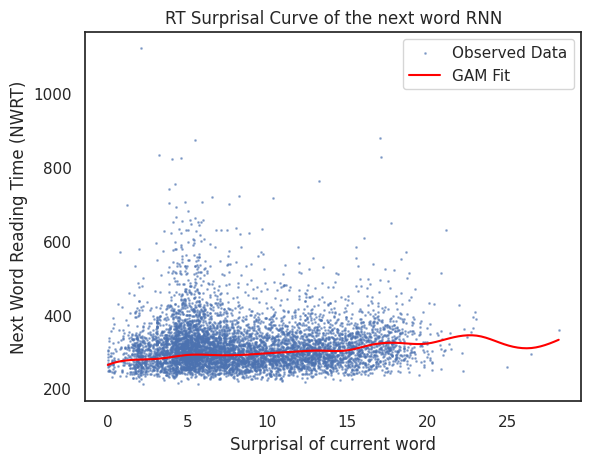

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     41.8786
Link Function:                     IdentityLink Log Likelihood:                                -62527.4618
Number of Samples:                         6778 AIC:                                           125140.6808
                                                AICc:                                          125141.2396
                                                GCV:                                             4093.5877
                                                Scale:                                           4048.0861
                                                Pseudo R-Squared:                                   0.0848
Feature Function                  Lam

<ipython-input-38-0c3ebab1f50c>:23: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_model.summary()


In [ ]:
### GAM surprisal estimates and next word rts

# Extract relevant columns for the GAM model
X = data_rnn[['surp', 'log_frequency', 'wlen']].values
y = data_rnn['next_word_rt'].values

# Fit the GAM model
gam_model = LinearGAM(s(0) + s(1) + s(2)).fit(X, y)

# Generate grid values for predictors
X_grid = gam_model.generate_X_grid(term=0, n=100)
# Predict the response variable using the fitted GAM model
y_pred = gam_model.predict(X_grid)

# Plot the RT surprisal curve
plt.scatter(data_rnn['surp'], data_rnn['next_word_rt'], alpha=0.5, label='Observed Data', s=1)
plt.plot(X_grid[:, 0], y_pred, color='red', label='GAM Fit')
plt.xlabel('Surprisal of current word')
plt.ylabel('Next Word Reading Time (NWRT)')
plt.legend()
plt.title('RT Surprisal Curve of the next word RNN')
plt.show()
gam_model.summary()

In [ ]:
full_harmonized_ngram

,sentence_id,token_id,token,surprisal,avg_rt,raw_probability,next_word_rt
0,1,1,in,4.57937,380.275294,0.041828,335.850588
1,1,2,unk,7.45049,335.850588,0.005717,296.042941
2,1,3,county,12.65410,296.042941,0.000155,481.850000
3,1,4,unk,6.11317,481.850000,0.014446,403.553529
4,1,5,near,12.22380,403.553529,0.000209,306.075882
...,...,...,...,...,...,...,...
7182,464,15,failed,8.25341,292.772500,0.003277,284.470833
7183,464,16,as,9.42416,284.470833,0.001456,282.622083
7184,464,17,a,3.23962,282.622083,0.105871,279.445417
7185,464,18,leader,12.81650,279.445417,0.000139,299.705000


In [ ]:
def get_wlen(x):
  return len(x)

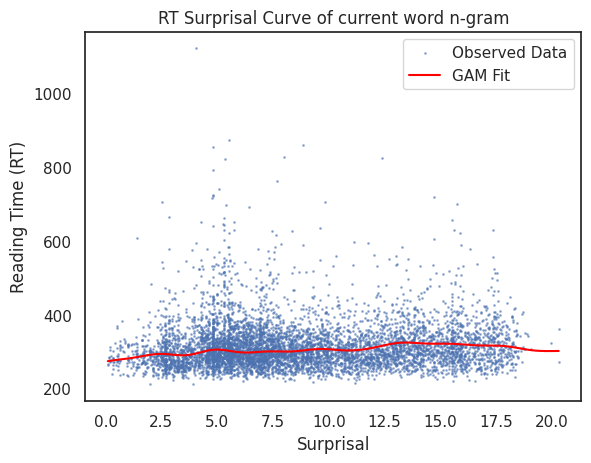

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     45.0773
Link Function:                     IdentityLink Log Likelihood:                                -61036.0687
Number of Samples:                         6678 AIC:                                            122164.292
                                                AICc:                                          122164.9463
                                                GCV:                                             3763.1724
                                                Scale:                                           3717.4767
                                                Pseudo R-Squared:                                   0.0805
Feature Function                  Lam

<ipython-input-41-ac47b2173f34>:31: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_model.summary()


In [ ]:
### GAM surprisal estimates and rts

# Preprocess the data
data_ngram = full_harmonized_ngram.copy()
data_ngram['log_frequency'] = data_ngram['token'].apply(count_frequency)
data_ngram['wlen'] = data_ngram['token'].apply(get_wlen)
data_ngram['map1'] = data_ngram['wlen'] * data_ngram['wlen']
data_ngram['map2'] = data_ngram['log_frequency'] * data_ngram['log_frequency']

# Extract relevant columns for the GAM model
X = data_ngram[['surprisal', 'log_frequency', 'wlen', 'map2']].values
y = data_ngram['avg_rt'].values

# Fit the GAM model
gam_model = LinearGAM(s(0) + s(1) + s(2)+s(3)).fit(X, y)

# Generate grid values for predictors
X_grid = gam_model.generate_X_grid(term=0, n=100)

# Predict the response variable using the fitted GAM model
y_pred = gam_model.predict(X_grid)

# Plot the RT surprisal curve
plt.scatter(data_ngram['surprisal'], data_ngram['avg_rt'], alpha=0.5, label='Observed Data', s=1)
plt.plot(X_grid[:, 0], y_pred, color='red', label='GAM Fit')
plt.xlabel('Surprisal')
plt.ylabel('Reading Time (RT)')
plt.legend()
plt.title('RT Surprisal Curve of current word n-gram')
plt.show()
gam_model.summary()

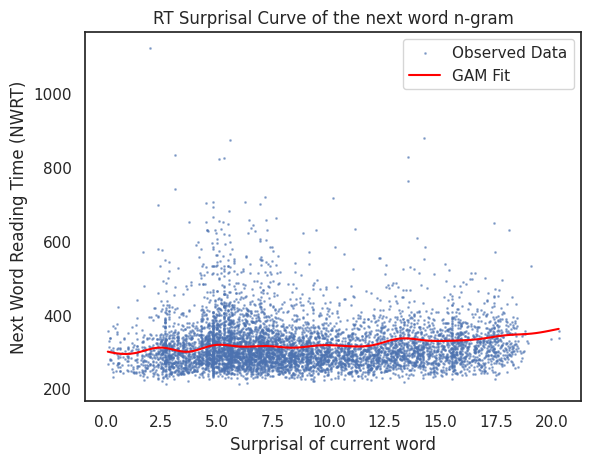

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     45.0773
Link Function:                     IdentityLink Log Likelihood:                                -61559.4967
Number of Samples:                         6678 AIC:                                            123211.148
                                                AICc:                                          123211.8022
                                                GCV:                                             4070.0421
                                                Scale:                                           4020.6201
                                                Pseudo R-Squared:                                   0.0872
Feature Function                  Lam

<ipython-input-42-ca75f3f58009>:23: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_model.summary()


In [ ]:
### GAM surprisal estimates and next word rts

# Extract relevant columns for the GAM model
X = data_ngram[['surprisal', 'log_frequency', 'wlen','map2']].values
y = data_ngram['next_word_rt'].values

# Fit the GAM model
gam_model = LinearGAM(s(0) + s(1) + s(2)+s(3)).fit(X, y)

# Generate grid values for predictors
X_grid = gam_model.generate_X_grid(term=0, n=100)
# Predict the response variable using the fitted GAM model
y_pred = gam_model.predict(X_grid)

# Plot the RT surprisal curve
plt.scatter(data_ngram['surprisal'], data_ngram['next_word_rt'], alpha=0.5, label='Observed Data', s=1)
plt.plot(X_grid[:, 0], y_pred, color='red', label='GAM Fit')
plt.xlabel('Surprisal of current word')
plt.ylabel('Next Word Reading Time (NWRT)')
plt.legend()
plt.title('RT Surprisal Curve of the next word n-gram')
plt.show()
gam_model.summary()

# Task 2

In [ ]:
!mkdir -p rnn/data2/rts
!mkdir -p rnn/data2/ptb
!mkdir -p "$GDRIVE_DIR/corpus_data2"

In [ ]:
  !wget -qO rnn/data2/ptb/MonolingualReadingData.xlsx https://expsy.ugent.be/downloads/geco/files/MonolingualReadingData.xlsx

In [ ]:
!cp rnn/data2/ptb/* "$GDRIVE_DIR/corpus_data2/"

In [ ]:
import pandas as pd
rts_geco = pd.read_excel('/content/rnn/data2/ptb/MonolingualReadingData.xlsx')

In [ ]:
temp = rts_geco[rts_geco['PP_NR'] == 'pp21']
temp = " ".join(list(temp['WORD'].astype(str)))

In [ ]:
f = open("rnn/data/test.txt", 'w')
f.write(temp)
f.close()

In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'test.txt' --test --words --nopp > "$GDRIVE_DIR/rnn_surprisals2.tsv"

Libraries loaded
Using beamsize: 23757


In [ ]:
rnn_surp_test = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals2.tsv',sep=' ', encoding='utf-8')
rnn_surp_test

,word,sentid,sentpos,wlen,surp,entropy,entred
0,The,0,0,3,3.103844,9.515585,0.000000
1,intense,0,1,7,14.203464,11.167587,0.000000
2,interest,0,2,8,9.746426,11.452054,0.000000
3,aroused,0,3,7,19.802402,5.640379,5.811675
4,in,0,4,2,3.544502,5.629477,0.010902
...,...,...,...,...,...,...,...
56449,<unk>,2727,4,5,7.508675,7.623295,0.789335
56450,who,2727,5,3,9.678910,8.531318,0.000000
56451,<unk>,2727,6,5,6.060735,9.377717,0.000000
56452,And,2728,0,3,6.432778,9.515585,0.000000


In [ ]:
r = rts_geco[rts_geco['PP_NR']=='pp22']
r['WORD_ID']

56410        1-5-1
56411        1-5-2
56412        1-5-3
56413        1-5-4
56414        1-5-5
            ...   
112815    4-141-68
112816    4-141-69
112817    4-141-70
112818    4-141-71
112819    4-141-72
Name: WORD_ID, Length: 56410, dtype: object

In [ ]:
rts_geco['word'] = rts_geco['WORD'].astype(str)
rts_geco['time'] = rts_geco['WORD_TOTAL_READING_TIME']
codes = list(rts_geco[rts_geco['PP_NR'] == 'pp21'].WORD_ID)
rts_geco['code'] = 0
for i, id in enumerate(codes):
  rts_geco.loc[rts_geco['WORD_ID'] == id, ['code']] = i

In [ ]:
rts_geco['time'] = rts_geco['time'].replace(['.'], 0)

In [ ]:
rts_geco['code']

0             0
1             1
2             2
3             3
4             4
          ...  
774010    56405
774011    56406
774012    56407
774013    56408
774014    56409
Name: code, Length: 774015, dtype: int64

In [ ]:
harmonized_rnn2 = harmonize(rts_geco, rnn_surp_test, 'word')
# harmonized_rnn2.drop(harmonized_rnn2[harmonized_rnn2['word'] == ''].index, inplace = True)
# harmonized_rnn2.drop(harmonized_rnn2[harmonized_rnn2['word'] == 'unk'].index, inplace = True)



0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
finito


In [ ]:
harmonized_rnn2.drop(harmonized_rnn2[harmonized_rnn2['word'] == ''].index, inplace = True)
harmonized_rnn2.drop(harmonized_rnn2[harmonized_rnn2['word'] == 'unk'].index, inplace = True)

In [ ]:
harmonized_rnn2

,word,sentid,sentpos,wlen,surp,entropy,entred,avg_rt
0,the,0,0,3,3.103844,9.515585,0.000000,276.785714
1,intense,0,1,7,14.203464,11.167587,0.000000,453.857143
2,interest,0,2,8,9.746426,11.452054,0.000000,403.285714
3,aroused,0,3,7,19.802402,5.640379,5.811675,355.785714
4,in,0,4,2,3.544502,5.629477,0.010902,100.785714
...,...,...,...,...,...,...,...,...
56402,may,2727,1,3,5.734422,7.047348,2.468237,132.076923
56403,hunt,2727,2,4,20.536190,7.080526,0.000000,184.923077
56404,together,2727,3,8,10.640580,8.412630,0.000000,193.846154
56406,who,2727,5,3,9.678910,8.531318,0.000000,95.461538


                            OLS Regression Results                            
Dep. Variable:                 avg_rt   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                 1.130e+04
Date:                Tue, 04 Jul 2023   Prob (F-statistic):               0.00
Time:                        17:24:22   Log-Likelihood:            -2.3504e+05
No. Observations:               40790   AIC:                         4.701e+05
Df Residuals:                   40788   BIC:                         4.701e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.9145      0.870     72.298      0.0

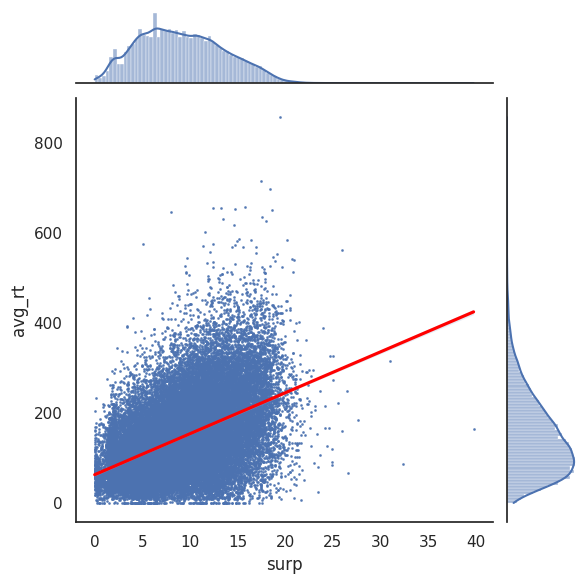

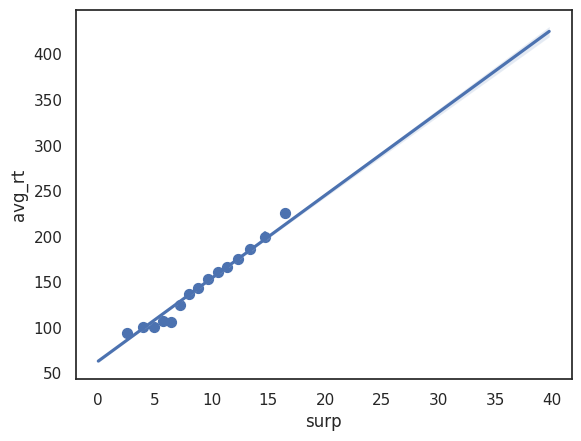

In [ ]:
analysis(harmonized_rnn2, 'surp')

In [ ]:
harmonized_rnn2.to_csv('harmonized_rnn2.csv')

open ended

In [ ]:
!pip install minicons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 894.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 29.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.13.1 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.13.1 which

In [ ]:
from minicons import scorer
import torch
from torch.utils.data import DataLoader

import numpy as np

import json

In [ ]:
model = scorer.IncrementalLMScorer('gpt2', 'cpu')

Using pad_token, but it is not set yet.


In [ ]:
!mkdir -p new

In [ ]:
!wget -qO new/MonolingualReadingData.xlsx https://expsy.ugent.be/downloads/geco/files/MonolingualReadingData.xlsx

In [ ]:
import pandas as pd
rts_geco = pd.read_excel('/content/new/MonolingualReadingData.xlsx')

In [ ]:
trials = list(set(rts_geco.TRIAL))

In [ ]:
rts_geco['WORD'] = rts_geco['WORD'].astype(str)

In [ ]:
parts = list(set(rts_geco['PART']))

In [ ]:
import string
def remove_panc(s):
  s = s.lower()
  s = s.translate(str.maketrans('', '', string.punctuation))
  s = s.replace('û ', '')
  s = s.replace('ami ', '')
  return s

In [ ]:
def remove_wrong(surps, temp):
  copy_surps = surps.copy()
  list_temp = temp.split(' ')
  indexes_to_remove = []
  count = 0
  for i, word in enumerate(copy_surps):
    k=i-len(indexes_to_remove)+1*count
    if (i not in indexes_to_remove) and (word[0] != list_temp[k]):
      count+=1
      part = word[0]
      indexes_to_remove.append(k)
      j=i
      while(part != list_temp[k]):
        j += 1
        part += surps[j][0]
        indexes_to_remove.append(j)
  copy_surps = [j for i, j in enumerate(copy_surps) if i not in indexes_to_remove]
  return copy_surps

In [ ]:
def indert_in_df(df, surps):
  copy_df = df.copy()
  copy_df['surp'] = -1
  copy_df['new_word'] = ""
  i=0
  for index, row in copy_df.iterrows():
    if remove_panc(copy_df.at[index,'WORD'])==surps[i][0]:
      copy_df.at[index,'surp'] = surps[i][1]
      copy_df.at[index,'new_word'] = surps[i][0]
      i += 1
  return copy_df

In [ ]:
temp = rts_geco[rts_geco['PP_NR']=='pp21']
temp = temp[temp['PART']==4]
temp = temp[temp['TRIAL']==56]
temp_text = ' '.join(list(temp.WORD))
temp_text = remove_panc(temp_text)
# model.tokenizer = Tokenzier(temp)
surps = model.token_score(temp_text, surprisal = True, base_two = True)[0]
surps = remove_wrong(surps,temp_text)[0]
surps
ss = indert_in_df(temp,surps)
ss = ss[ss['surp']!=-1][['new_word','WORD_ID','surp']]


In [ ]:
df_surps_ids = {'new_word':[],'WORD_ID':[],'surp':[]}
df_surps_ids = pd.DataFrame(data=df_surps_ids)

,new_word,WORD_ID,surp


In [ ]:
from tqdm import tqdm

parts_text = {1: "", 2: "", 3: "", 4: ""}
check = ""
for p in parts:
  for trial in tqdm(trials):
    temp = rts_geco[rts_geco['PP_NR']=='pp21']
    temp = temp[temp['PART']==p]
    temp = temp[temp['TRIAL']==trial]
    temp_text = ' '.join(list(temp.WORD))
    temp_text = remove_panc(temp_text)
    if len(temp_text):
      surps = model.token_score(temp_text, surprisal = True, base_two = True)[0]
      surps = remove_wrong(surps,temp_text)
      ss = indert_in_df(temp,surps)
      ss = ss[ss['surp']!=-1][['new_word','WORD_ID','surp']]
      df_surps_ids = pd.concat([df_surps_ids, ss])

100%|██████████| 160/160 [01:52<00:00,  1.42it/s]


In [ ]:
df_surps_ids.to_csv("df_surps_ids.csv")
good_ids = list(df_surps_ids.WORD_ID)

In [ ]:
rts_geco = rts_geco.replace('.', 0)
good_rts_geco = rts_geco[rts_geco['WORD_ID'].isin(good_ids)]
good_rts_geco

,PP_NR,GROUP,LANGUAGE_RANK,LANGUAGE,PART,TRIAL,TRIAL_FIXATION_COUNT,TRIAL_TOTAL_READING_TIME,WORD_ID_WITHIN_TRIAL,WORD_ID,...,WORD_LAST_FIXATION_RUN,WORD_LAST_FIXATION_TIME,WORD_LAST_FIXATION_X,WORD_LAST_FIXATION_Y,WORD_GO_PAST_TIME,WORD_SELECTIVE_GO_PAST_TIME,WORD_TOTAL_READING_TIME,WORD_TOTAL_READING_TIME_%,WORD_SPILLOVER,WORD_SKIP
0,pp21,monolingual,L1,English,1,5,115,25429,1,1-5-1,...,2,357,115.6,104.6,95,95,381,0.0150,0,0
1,pp21,monolingual,L1,English,1,5,115,25429,2,1-5-2,...,3,1392,163.8,107.0,582,296,828,0.0326,0,1
2,pp21,monolingual,L1,English,1,5,115,25429,3,1-5-3,...,2,1957,229.4,96.6,1097,565,565,0.0222,0,1
3,pp21,monolingual,L1,English,1,5,115,25429,4,1-5-4,...,2,2474,356.0,103.8,2107,428,428,0.0168,0,0
4,pp21,monolingual,L1,English,1,5,115,25429,5,1-5-5,...,1,2808,403.2,114.5,154,154,154,0.0061,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773757,pp35,monolingual,L1,English,4,139,85,20636,17,4-139-17,...,0,0,0.0,0.0,0,0,0,0.0000,0,1
773758,pp35,monolingual,L1,English,4,139,85,20636,18,4-139-18,...,1,3048,168.9,185.3,351,351,351,0.0170,0,0
773759,pp35,monolingual,L1,English,4,139,85,20636,19,4-139-19,...,0,0,0.0,0.0,0,0,0,0.0000,0,1
773761,pp35,monolingual,L1,English,4,139,85,20636,21,4-139-21,...,0,0,0.0,0.0,0,0,0,0.0000,0,1


In [ ]:
good_rts_geco['avg_rt'] = 0
avg_rt_by_id = {}
for id in good_ids:
  rts = list(rts_geco[rts_geco['WORD_ID']==id].WORD_TOTAL_READING_TIME)
  avg_rt_by_id[id] = np.mean(rts)

avg_rt_by_id

<ipython-input-199-224498183460>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_rts_geco['avg_rt'] = 0


{'1-5-1': 276.7857142857143,
 '1-5-2': 453.85714285714283,
 '1-5-3': 403.2857142857143,
 '1-5-4': 355.7857142857143,
 '1-5-5': 100.78571428571429,
 '1-5-6': 211.85714285714286,
 '1-5-7': 188.64285714285714,
 '1-5-8': 146.35714285714286,
 '1-5-9': 263.64285714285717,
 '1-5-10': 95.64285714285714,
 '1-5-11': 96.92857142857143,
 '1-5-12': 77.92857142857143,
 '1-5-13': 151.5,
 '1-5-14': 162.78571428571428,
 '1-5-15': 44.214285714285715,
 '1-5-16': 134.92857142857142,
 '1-5-17': 461.57142857142856,
 '1-5-18': 306.2857142857143,
 '1-5-19': 224.5,
 '1-5-20': 224.78571428571428,
 '1-5-21': 308.5,
 '1-5-23': 441.85714285714283,
 '1-5-24': 129.71428571428572,
 '1-5-25': 276.7857142857143,
 '1-5-26': 106.21428571428571,
 '1-5-27': 102.14285714285714,
 '1-5-28': 459.7857142857143,
 '1-5-29': 715.4285714285714,
 '1-5-30': 207.71428571428572,
 '1-5-31': 292.7857142857143,
 '1-5-32': 108.78571428571429,
 '1-5-33': 90.0,
 '1-5-34': 104.92857142857143,
 '1-5-35': 168.5,
 '1-5-36': 181.14285714285714,
 

In [ ]:
from tqdm import tqdm
for k in tqdm(avg_rt_by_id.keys()):
  df_surps_ids.loc[df_surps_ids.WORD_ID == k, 'avg_rt'] = avg_rt_by_id[k]

100%|██████████| 11633/11633 [00:26<00:00, 435.23it/s]


In [ ]:
df_surps_ids

,new_word,WORD_ID,surp,avg_rt
0,the,1-5-1,0.000000,276.785714
1,intense,1-5-2,14.776893,453.857143
2,interest,1-5-3,7.762136,403.285714
3,aroused,1-5-4,13.075965,355.785714
4,in,1-5-5,3.246966,100.785714
...,...,...,...,...
56152,the,4-139-17,2.318711,93.615385
56153,door,4-139-18,1.008011,175.000000
56154,and,4-139-19,2.121347,35.769231
56156,her,4-139-21,2.480282,134.230769


                            OLS Regression Results                            
Dep. Variable:                 avg_rt   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     2922.
Date:                Tue, 04 Jul 2023   Prob (F-statistic):               0.00
Time:                        20:37:22   Log-Likelihood:            -1.2596e+05
No. Observations:               21556   AIC:                         2.519e+05
Df Residuals:                   21554   BIC:                         2.519e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.9784      0.995    108.487      0.0

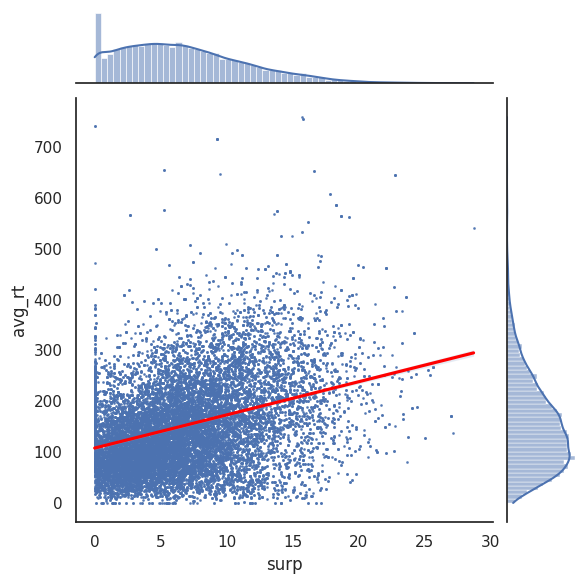

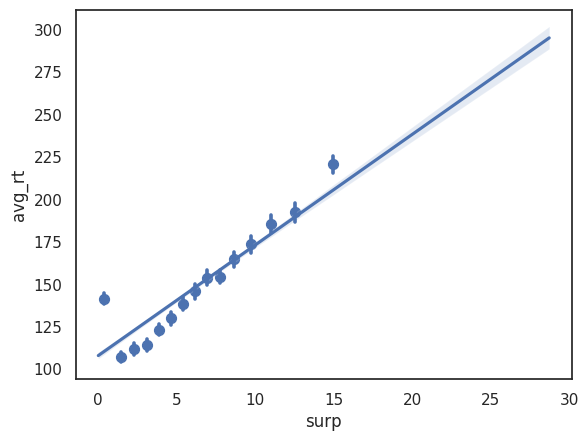

In [ ]:
analysis(df_surps_ids, 'surp')

In [ ]:
df_surps_ids['next_rt'] = 0
for index, row in df_surps_ids.iterrows():
  if index <